# Timeseries Forecasting using RNN

Competition - https://www.kaggle.com/c/bike-sharing-demand/data  
Provided with hourly rental data spanning two years  
The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month.  
Predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.


References:
- https://www.youtube.com/watch?v=ne-dpRdNReI (Notebook found here https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb )
- https://www.youtube.com/watch?v=6f67zrH-_IE (output layer of RNN needs to be scaled based on input layer of data)
- https://towardsdatascience.com/sequence-to-sequence-model-introduction-and-concepts-44d9b41cd42d
-  https://github.com/patternedscience/time-series-tf-serving/blob/master/seq2seq-model-training-exporting.ipynb


Version:  
V1 problem framing - RNN with sigmoid activation in final layer with scaling and MSE custom loss function  
V2 RNN fitted but validation loss is nan and causing early stopping to happen  
V3-4 Baseline submission done (fixed nan issue have yet to apply early stopping back)  
V5 Use https://www.kaggle.com/drcapa/bike-sharing-demand-rnn as inspiration to impute train and test missing timesteps so that hardcoding of data generator doesn't need to be done, thus increasing number batches  
V6-v7 - use fit instead of fit generator as we don't have CPU constraints, change warmup steps, note train loss decreases as val loss increases?? don't impute x_test as submission file will error. okay this was worse :(  
v8 (WIP) : change data generator to have x's be today's data and y's be 24 timesteps ahead.  Big learning where prediction requires data generation too!

Note similar notebook - https://www.kaggle.com/drcapa/bike-sharing-demand-rnn/notebook


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
import calendar
from datetime import datetime

X = pd.read_csv('../input/bike-sharing-demand/train.csv',parse_dates = ['datetime'],
                        index_col='datetime', infer_datetime_format=True) ## 2011-01-01 to 2012-12-19
X_test = pd.read_csv('../input/bike-sharing-demand/test.csv',parse_dates = ['datetime'],
                        index_col='datetime', infer_datetime_format=True) # doesn't contain ['casual','registered','count']

In [3]:
X.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
X_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
# X = X
# Y = X[TARGET_NAMES].shift(-FUTURE_PERIOD_PREDICT)
#X_val = validate.drop(columns=TARGET_NAMES)
#Y_val = validate[TARGET_NAMES]

In [6]:
# X.head(FUTURE_PERIOD_PREDICT+5) # check if Y_train has been shifted in the correct direction

# Imputation
This section is from https://www.kaggle.com/drcapa/bike-sharing-demand-rnn#Missing-Timestamps

In [7]:
year_list = X.index.year.unique()

In [8]:
X_temp = pd.DataFrame(columns=X.columns)

for year in year_list:
    for month in range(12):
        start_date = datetime(year, month+1, 1, 0, 0, 0)
        end_date = datetime(year, month+1, 19, 23, 0, 0)
        # Fill missing timestamps
        # convenience method - https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling
        temp = X[start_date:end_date].resample('H').asfreq()
        # Handle missing values
        features_fill_zero = ['casual', 'registered', 'count']
        temp[features_fill_zero] = temp[features_fill_zero].fillna(0) 
        features_fill_bbfil = ['season', 'holiday', 'workingday', 'weather']
        temp[features_fill_bbfil] = temp[features_fill_bbfil].fillna(method='bfill') # use next timestep to impute
        features_fill_linear = ['temp', 'atemp', 'humidity', 'windspeed']
        temp[features_fill_linear] = temp[features_fill_linear].interpolate(method='linear')
        
        X_temp = X_temp.append(temp)

In [9]:
start_date = datetime(2011, 0+1, 1, 0, 0, 0)
end_date = datetime(2011, 0+1, 19, 23, 0, 0)
temp = X[start_date:end_date].resample('H').asfreq()
temp.iloc[25:31,] # example of reample NaN

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-02 01:00:00,1.0,0.0,0.0,2.0,18.04,21.970,94.0,16.9979,1.0,16.0,17.0
2011-01-02 02:00:00,1.0,0.0,0.0,2.0,17.22,21.210,100.0,19.0012,1.0,8.0,9.0
2011-01-02 03:00:00,1.0,0.0,0.0,2.0,18.86,22.725,94.0,12.9980,2.0,4.0,6.0
2011-01-02 04:00:00,1.0,0.0,0.0,2.0,18.86,22.725,94.0,12.9980,2.0,1.0,3.0
2011-01-02 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-02 06:00:00,1.0,0.0,0.0,3.0,17.22,21.210,77.0,19.9995,0.0,2.0,2.0


In [10]:
features_fill_zero = ['casual', 'registered', 'count']
temp[features_fill_zero] = temp[features_fill_zero].fillna(0)
features_fill_bbfil = ['season', 'holiday', 'workingday', 'weather']
temp[features_fill_bbfil] = temp[features_fill_bbfil].fillna(method='bfill')
features_fill_linear = ['temp', 'atemp', 'humidity', 'windspeed']
temp[features_fill_linear] = temp[features_fill_linear].interpolate(method='linear') # takes the average between prev and next timestep

In [11]:
temp.iloc[25:31,]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-02 01:00:00,1.0,0.0,0.0,2.0,18.04,21.9700,94.0,16.99790,1.0,16.0,17.0
2011-01-02 02:00:00,1.0,0.0,0.0,2.0,17.22,21.2100,100.0,19.00120,1.0,8.0,9.0
2011-01-02 03:00:00,1.0,0.0,0.0,2.0,18.86,22.7250,94.0,12.99800,2.0,4.0,6.0
2011-01-02 04:00:00,1.0,0.0,0.0,2.0,18.86,22.7250,94.0,12.99800,2.0,1.0,3.0
2011-01-02 05:00:00,1.0,0.0,0.0,3.0,18.04,21.9675,85.5,16.49875,0.0,0.0,0.0
2011-01-02 06:00:00,1.0,0.0,0.0,3.0,17.22,21.2100,77.0,19.99950,0.0,2.0,2.0


In [12]:
X = X_temp

In [13]:
X = X_temp.drop(columns=['casual','registered', 'count'])
Y = X_temp[['count']]

## Data Preprocessing

In [14]:
SEQ_LEN = 24
FUTURE_PERIOD_PREDICT = 24
COUNT_TARGETS =  ['casual', 'registered', 'count']
TARGET_NAME = ['count']
BINARY_FEATURES = ['holiday','workingday']
CATEGORICAL_FEATURES = ['season', 'weather']
CONTINUOUS_FEATURES = ['temp', 'atemp', 'humidity', 'windspeed']
ALL_FEATURES = ['season', 'holiday', 'workingday', 'weather']

In [15]:
x_ohe = preprocessing.OneHotEncoder()
x_ohe.fit(X[CATEGORICAL_FEATURES]) # x_ohe.categories_
X_cat = pd.DataFrame(x_ohe.transform(X[CATEGORICAL_FEATURES]).toarray(), columns=x_ohe.get_feature_names(CATEGORICAL_FEATURES), index=X.index)


In [16]:
X = X.merge(X_cat,left_index=True, right_index=True).drop(columns=CATEGORICAL_FEATURES)

In [17]:
x_scaler = preprocessing.MinMaxScaler() # scale continuous features
x_scaler.fit(X[CONTINUOUS_FEATURES])

MinMaxScaler()

In [18]:
['_'.join([col,"scaled"]) for col in CONTINUOUS_FEATURES]

['temp_scaled', 'atemp_scaled', 'humidity_scaled', 'windspeed_scaled']

In [19]:
# shape is (10886, 6)
X_cont = pd.DataFrame(x_scaler.transform(X[CONTINUOUS_FEATURES]), columns = ['_'.join([col,"scaled"]) for col in CONTINUOUS_FEATURES], index = X.index)

In [20]:
X_cont.head()

,temp_scaled,atemp_scaled,humidity_scaled,windspeed_scaled
2011-01-01 00:00:00,0.224490,0.305068,0.81,0.0
2011-01-01 01:00:00,0.204082,0.288064,0.80,0.0
2011-01-01 02:00:00,0.204082,0.288064,0.80,0.0
2011-01-01 03:00:00,0.224490,0.305068,0.75,0.0
2011-01-01 04:00:00,0.224490,0.305068,0.75,0.0


In [21]:
X_new = X.merge(X_cont,left_index=True, right_index=True).drop(columns=CONTINUOUS_FEATURES)

In [22]:
SCALED_FEATURES = ['_'.join([col,"scaled"]) for col in CONTINUOUS_FEATURES]

In [23]:
print("Min :\n", np.min(X_new[SCALED_FEATURES]))
print("Max :\n", np.max(X_new[SCALED_FEATURES]))

Min :
 temp_scaled         0.0
atemp_scaled        0.0
humidity_scaled     0.0
windspeed_scaled    0.0
dtype: float64
Max :
 temp_scaled         1.0
atemp_scaled        1.0
humidity_scaled     1.0
windspeed_scaled    1.0
dtype: float64


In [24]:
# need a separate scaler as we wanted to reuse the sclaer for X variables for our test set
Y_scaler = preprocessing.MinMaxScaler()
Y_scaler.fit(Y)
Y_target = Y_scaler.transform(Y)

In [25]:
Y_target= pd.DataFrame(Y_target, columns=TARGET_NAME, index = Y.index)

In [26]:
Y_target.head()

,count
2011-01-01 00:00:00,0.016377
2011-01-01 01:00:00,0.040942
2011-01-01 02:00:00,0.032753
2011-01-01 03:00:00,0.013306
2011-01-01 04:00:00,0.001024


In [27]:
X_new.head()

,holiday,workingday,season_1.0,season_2.0,season_3.0,season_4.0,weather_1.0,weather_2.0,weather_3.0,weather_4.0,temp_scaled,atemp_scaled,humidity_scaled,windspeed_scaled
2011-01-01 00:00:00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.224490,0.305068,0.81,0.0
2011-01-01 01:00:00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.204082,0.288064,0.80,0.0
2011-01-01 02:00:00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.204082,0.288064,0.80,0.0
2011-01-01 03:00:00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.224490,0.305068,0.75,0.0
2011-01-01 04:00:00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.224490,0.305068,0.75,0.0


## Create Data Generator

In [28]:
STARTS = X.index[(X.index.day == 1 ) & (X.index.hour == 0)]

In [29]:
STARTS

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01',
               '2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01'],
              dtype='datetime64[ns]', freq=None)

In [30]:
np.where(X.index == STARTS[1])[0][0]

456

In [31]:
X_new.columns

Index(['holiday', 'workingday', 'season_1.0', 'season_2.0', 'season_3.0',
       'season_4.0', 'weather_1.0', 'weather_2.0', 'weather_3.0',
       'weather_4.0', 'temp_scaled', 'atemp_scaled', 'humidity_scaled',
       'windspeed_scaled'],
      dtype='object')

In [32]:
SEQUENCE_LENGTH = 24 
BATCH_SIZE = X_new.shape[0] - SEQUENCE_LENGTH - 1
NUM_X_SIGNALS = X_new.shape[1]
NUM_Y_SIGNALS = Y_target.shape[1]

In [51]:
def batch_generator(sequence_length):
    while True:
        batch_size = X_new.shape[0] - sequence_length
        x_shape = (batch_size, sequence_length, NUM_X_SIGNALS)
        x_batch = np.zeros(shape=x_shape, dtype = np.float16)

        y_shape = (batch_size, Y_target.shape[1], NUM_Y_SIGNALS) #Y_target.shape[1] is just 1 for 'counts'
        y_batch = np.zeros(shape=y_shape, dtype = np.float16)
        

        for i in range(batch_size): # 24 time periods
            x_batch[i] = X_new.iloc[i:i+sequence_length]
            y_batch[i] = Y_target.iloc[i+sequence_length+1]

        yield (x_batch, y_batch)
    

In [52]:
generator = batch_generator(batch_size=BATCH_SIZE, sequence_length=SEQUENCE_LENGTH)

TypeError: batch_generator() got an unexpected keyword argument 'batch_size'

In [53]:
x_batch, y_batch = next(generator)

In [ ]:
x_batch

In [56]:
Y_target[25:]

,count
2011-01-02 01:00:00,0.017400
2011-01-02 02:00:00,0.009212
2011-01-02 03:00:00,0.006141
2011-01-02 04:00:00,0.003071
2011-01-02 05:00:00,0.000000
...,...
2012-12-19 19:00:00,0.343910
2012-12-19 20:00:00,0.246673
2012-12-19 21:00:00,0.171955
2012-12-19 22:00:00,0.132037


In [54]:
y_batch

array([[[0.0174 ],
        [0.0174 ],
        [0.0174 ],
        ...,
        [0.0174 ],
        [0.0174 ],
        [0.0174 ]],

       [[0.00921],
        [0.00921],
        [0.00921],
        ...,
        [0.00921],
        [0.00921],
        [0.00921]],

       [[0.00614],
        [0.00614],
        [0.00614],
        ...,
        [0.00614],
        [0.00614],
        [0.00614]],

       ...,

       [[0.172  ],
        [0.172  ],
        [0.172  ],
        ...,
        [0.172  ],
        [0.172  ],
        [0.172  ]],

       [[0.1321 ],
        [0.1321 ],
        [0.1321 ],
        ...,
        [0.1321 ],
        [0.1321 ],
        [0.1321 ]],

       [[0.0901 ],
        [0.0901 ],
        [0.0901 ],
        ...,
        [0.0901 ],
        [0.0901 ],
        [0.0901 ]]], dtype=float16)

In [48]:
print(x_batch.shape)
print(y_batch.shape)

(10919, 24, 14)
(10919, 24, 1)


In [49]:
validation_data = (np.expand_dims(X_new, axis=0), np.expand_dims(Y_target, axis=0)) # note last 24 hours has missing counts

In [38]:
# expand dimensionality of data such that it's like a batch with 1 sequence of data
print(validation_data[0].shape)
print(validation_data[1].shape) 

(1, 10944, 14)
(1, 10944, 1)


## GRU - Proposed Architecture

Taken from https://www.youtube.com/watch?v=6f67zrH-_IE
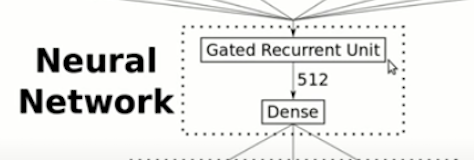

In [39]:
model = tf.keras.Sequential()

In [40]:
model.add(tf.keras.layers.GRU(units=512, # GRU outputs a sequence of 512, then in next layer maps to the 3 NUM_Y_SIGNALS
                          #SEQUENCE_LENGTH, 
                          return_sequences=True, # set to True if next layer is recurrent, if False, next layer is Dense
                          input_shape=(None,NUM_X_SIGNALS,))) # initial layer receives one batch of data with an arbitrary length of sequence and number of input signals
# CuDNNLSTM is very fast - check this out

In [41]:
# the output signals of the net is between 0 and 1 so we use sigmoid to squish between 0 and 1
# can only putput values that's in the same range as training data
model.add(tf.keras.layers.Dense(NUM_Y_SIGNALS,activation='sigmoid')) 

In [42]:
# Alternatively, the final layer can be a dense layer with linear activation function
# for more complex architecture, would need to initalize with smaller numbers to prevent NaN, training may explode
if False:
    init = tf.python.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05)
    model.add(Dense(NUM_Y_SIGNALS, activation='linear',kernel_initializer=init))


In [43]:
## Custom Loss Function for MSE
WARM_UP_STEPS = 3
def loss_mse_warmup(y_true, y_pred):
    
    # ignore the "warm up steps" of the sequences 
    # the shape of these tensors are [batch_size, sequence_length - WARM_UP_STEPS , num_y_signals]
    y_true_slice = y_true[:, WARM_UP_STEPS:, :]
    y_pred_slice = y_pred[:, WARM_UP_STEPS:, :]
    
    # calculate the mse
    loss = tf.losses.MSE(y_true = y_true_slice,
                         y_pred = y_pred_slice)
    
    # keras may reduce this across a single axis (the batch) 
    # to be sure, we reduce the loss to a single scalar 
    loss_mean = tf.reduce_mean(loss)
    
    return loss_mean

In [180]:
optimizer = tf.keras.optimizers.RMSprop(lr=0.00001)

In [181]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [182]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         811008    
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           513       
Total params: 811,521
Trainable params: 811,521
Non-trainable params: 0
_________________________________________________________________


## Callback Functions
During training we want to save checkpoints and log the progress to tensorboard so we can create appropriate callbacks to Keras

In [183]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
                                     monitor='val_loss',
                                     verbose=1,
                                     save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the model for stopping optimization when performance worsens on the validation-set

In [184]:
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1)

In [185]:
callback_tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./23_logs/',
                                  histogram_freq=0,
                                  write_graph=False)

callback reduces learning rate if val loss hasn't decreased since last epoch (as indicated by patience=0) then multiplies the lr by the factor and does not allow it to go below 0.0001

In [186]:
callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr = 0.00001,
                                       patience=0,
                                       verbose=1)

In [187]:
callbacks = [callback_checkpoint, callback_early_stopping,callback_tensorboard, callback_reduce_lr]

## Train RNN

Issues of Exploding Gradients is causing my validation loss to be nan  
Backpropogation through time https://www.youtube.com/watch?v=esgbmJ6SnSY
Some ways to overcome (http://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/readings/L15%20Exploding%20and%20Vanishing%20Gradients.pdf):
1. Gradient Clipping
2. Identity Initiating

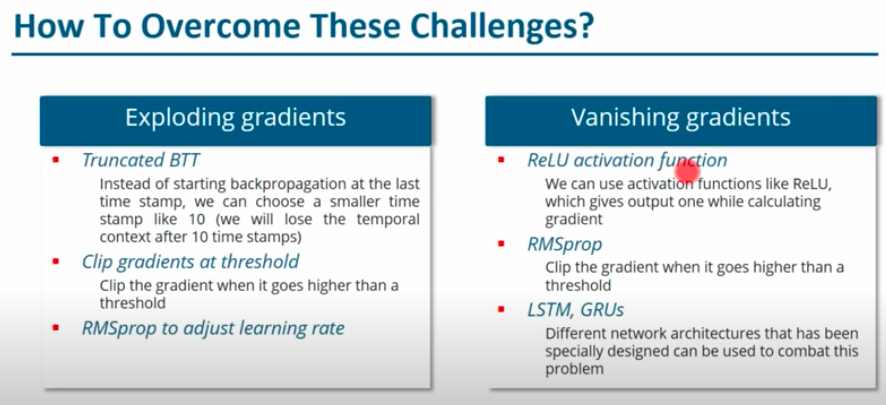
Taken from https://www.youtube.com/watch?v=y7qrilE-Zlc
Difference between fit() and fit_generator()
- https://datascience.stackexchange.com/questions/34444/what-is-the-difference-between-fit-and-fit-generator-in-keras

In [188]:
np.sum(np.isnan(x_batch))

0

In [192]:
%%time
# use fit_generator
# https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/#:~:text=fit%20is%20used%20when%20the,augmentation%20needs%20to%20be%20applied.
#history = model.fit_generator(generator=generator,
history = model.fit(x_batch, y_batch, epochs=50,
                    steps_per_epoch= 24, # usually set to num_rows / batch_size 
                   validation_data=validation_data,
                   callbacks=callbacks)

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 0.0302
Epoch 00001: val_loss improved from 0.02955 to 0.02927, saving model to 23_checkpoint.keras
24/24 [==============================] - 16s 677ms/step - loss: 0.0302 - val_loss: 0.0293 - lr: 1.0000e-05
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 0.0299
Epoch 00002: val_loss improved from 0.02927 to 0.02902, saving model to 23_checkpoint.keras
24/24 [==============================] - 16s 656ms/step - loss: 0.0299 - val_loss: 0.0290 - lr: 1.0000e-05
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.0297
Epoch 00003: val_loss improved from 0.02902 to 0.02876, saving model to 23_checkpoint.keras
24/24 [==============================] - 16s 654ms/step - loss: 0.0297 - val_loss: 0.0288 - lr: 1.0000e-05
Epoch 4/50
24/24 [==============================] - ETA: 0s - loss: 0.0294
Epoch 00004: val_loss improved from 0.02876 to 0.02849, saving model to 23_checkpoint.keras
24/24 [====

KeyboardInterrupt: 

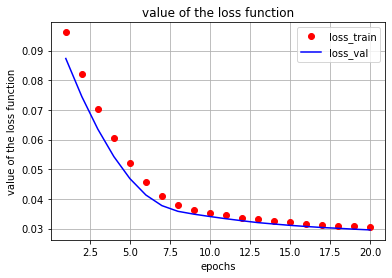

In [193]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'ro', label='loss_train')
plt.plot(epochs, val_loss, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# https://www.tensorflow.org/tensorboard/get_started
%load_ext tensorboard

## Load Model

In [ ]:
# kaggle specific path
path_checkpoint = '../output/kaggle/working/training/' + path_checkpoint
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error Trying to load checkpoint")
    print(error)

## Performance on Test Set

In [144]:
X_cat_test = pd.DataFrame(x_ohe.transform(X_test[CATEGORICAL_FEATURES]).toarray(), columns=x_ohe.get_feature_names(CATEGORICAL_FEATURES), index=X_test.index)

In [145]:
X_cont_test = pd.DataFrame(x_scaler.transform(X_test[CONTINUOUS_FEATURES]), columns = ['_'.join([col,"scaled"]) for col in CONTINUOUS_FEATURES], index = X_test.index)

In [146]:
X_test_scaled = X_cat_test.merge(X_cont_test, left_index=True, right_index=True)
X_test_scaled = X_test_scaled.merge(X_test[['holiday', 'workingday']], left_index=True, right_index=True)

In [147]:
X_test_scaled.shape

(6493, 14)

In [194]:
y_test_scaled = model.predict(np.expand_dims(X_test_scaled,axis=0))

In [149]:
y_test_scaled[0]

array([[0.40325347],
       [0.2832238 ],
       [0.18848744],
       ...,
       [0.3136529 ],
       [0.31338632],
       [0.31605354]], dtype=float32)

In [150]:
y_test_submission = Y_scaler.inverse_transform(y_test_scaled[0])

In [151]:
y_test_submission

array([[393.97864],
       [276.70966],
       [184.15222],
       ...,
       [306.43887],
       [306.17844],
       [308.7843 ]], dtype=float32)

In [153]:
submission = pd.read_csv('../input/bike-sharing-demand/sampleSubmission.csv') # doesn't contain ['casual','registered','count']

In [154]:
submission['count'] = y_test_submission

In [155]:
submission.to_csv('submission.csv',index=False)

Quick Refresher on Sequential Modelling
Gates:
- R_u is the *update* gate, intuition here is say you have a sentence "The cat, which ... , was full" and you want to predict the next word at the "was" step. You want the network to remember that the "cat" is singlular so you need an additional parameter such as R_u to remember that for you so that at the "was" timestep, it predicts "was" instead of "were".

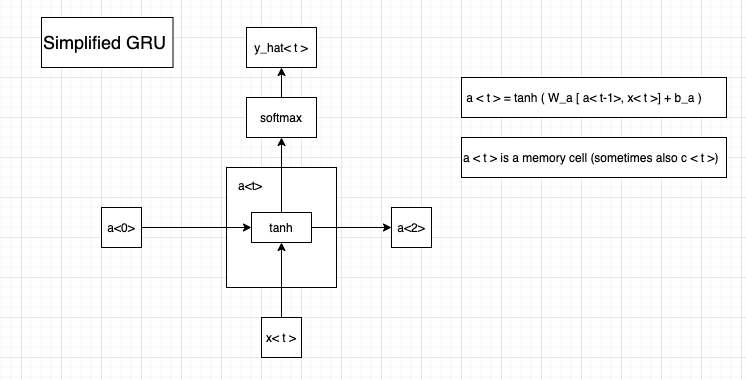

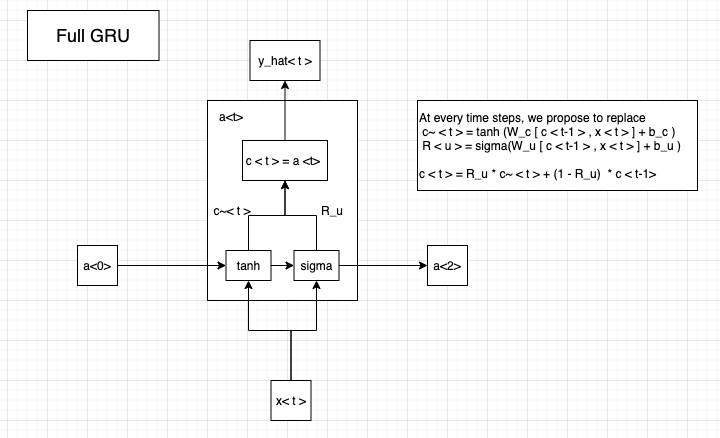